In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install ipython-autotime
%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1831 sha256=8eb864f80c3309341c633f43fb9707de77bbc9b184c63b326af5a17fe8565b14
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


In [ ]:
import os
import cv2
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input,Conv2D,Activation,Dense,Lambda,Flatten,Embedding,PReLU,BatchNormalization,GlobalAveragePooling2D,Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras import backend as K
from keras.utils.vis_utils import plot_model
from keras.models import load_model


from keras.applications import ResNet50

time: 1.97 s


In [ ]:
!gdown https://drive.google.com/uc?id=1WwGOMwyPlthp0ZF8f58VKrjRTkwUfDpZ
!unzip data.zip

In [ ]:
%cd /content/drive/My Drive/dog_vs_cat/

/content/drive/My Drive/dog_vs_cat
time: 4.33 s


In [ ]:
list = os.listdir('/content/data/train/dog/')
nbr_dog = len(list)
list = os.listdir('/content/data/train/cat/')
nbr_cat = len(list)
print('Total number of dog: ' + str(nbr_dog))
print('Total number of cat: ' + str(nbr_cat))
nbr_data = nbr_dog + nbr_cat
#should be 25000
print('Total number of data: ' + str(nbr_data))

Total number of dog: 12500
Total number of cat: 12500
Total number of data: 25000
time: 46.9 ms


In [ ]:
list = os.listdir('/content/data/test/')
nbr_test = len(list)
#should be 12500
print('Total number of test: ' + str(nbr_test))

Total number of test: 12500
time: 24.7 ms


In [ ]:
train_dir = '/content/data/train/'
test_dir = '/content/data/test/'

time: 1.72 ms


In [ ]:
datagen = ImageDataGenerator(
                             horizontal_flip=True, 
                             zoom_range=0.1,
                             fill_mode="constant",
                             channel_shift_range=10,
                             rotation_range=5,
                             width_shift_range=0.05,
                             height_shift_range=0.05,
                             validation_split = 0.2,
                             rescale=1./255
                             )

time: 11.8 ms


In [ ]:
batchSize = 32

train_gen = datagen.flow_from_directory(
                                        train_dir,
                                        target_size=(224, 224),
                                        color_mode="rgb",
                                        shuffle=True,
                                        class_mode='binary',
                                        batch_size=batchSize,
                                        seed = 44,
                                        subset="training",
                                        interpolation="nearest"
                                        )

val_gen = datagen.flow_from_directory(
                                        train_dir,
                                        target_size=(224, 224),
                                        color_mode="rgb",
                                        shuffle=True,
                                        class_mode='binary',
                                        batch_size=batchSize,
                                        seed = 44,
                                        subset="validation",
                                        interpolation="nearest"
                                        )

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
time: 712 ms


In [ ]:
def my_model(input_shape1, dropout, learning_rate = 0.0005):
    

    base_model = ResNet50(weights = 'imagenet', include_top=False)

    # for layer in base_model.layers[:]:
    #     layer.trainable = False

    model_input_1 = Input(input_shape1)
    x = base_model(model_input_1)
    x = GlobalAveragePooling2D()(x)
    
    y1 = Dense(1024,activation='relu')(x)
    y1 = Dropout(dropout)(y1)
    y1 = Dense(1024,activation='relu')(y1)
    y1 = Dropout(dropout)(y1)
    y1 = Dense(512,activation='relu')(y1)
    y1 = Dropout(dropout)(y1)
    y1 = Dense(256,activation='relu')(y1)
    y1 = Dropout(dropout)(y1)
    
    y1_h = Dense(1, activation = 'sigmoid', name = 'Class')(y1)

    model = Model(inputs=[model_input_1], outputs= [y1_h])
    
    optimizer = Adam(learning_rate=learning_rate)
    
    model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
    
    return model

time: 11.3 ms


In [ ]:
model = my_model(input_shape1 = (224,224,3), dropout = 0.2)
model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_______________________________________________________

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min',save_best_only=True,verbose=1)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.8, 
                                            min_lr=0.00001)

time: 2.95 ms


In [ ]:
train_steps = int(nbr_data * 0.8)//batchSize
val_steps = int(nbr_data * 0.2)//batchSize

# for test
# train_steps = 10
# val_steps = 2


print('Training steps: '+ str(train_steps))
print('Validation steps: ' + str(val_steps))

Training steps: 625
Validation steps: 156
time: 3.47 ms


In [ ]:
#train model 
epochs = 80

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=epochs,validation_data=val_gen, validation_steps=val_steps, callbacks=[learning_rate_reduction,es,mc])

model.save("last_model.h5")

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/80
625/625 [==============================] - ETA: 0s - loss: 0.1933 - accuracy: 0.9235
Epoch 00001: val_loss improved from inf to 0.67455, saving model to best_model.h5
625/625 [==============================] - 388s 621ms/step - loss: 0.1933 - accuracy: 0.9235 - val_loss: 0.6745 - val_accuracy: 0.5198
Epoch 2/80
625/625 [==============================] - ETA: 0s - loss: 0.1277 - accuracy: 0.9514
Epoch 00002: val_loss improved from 0.67455 to 0.42833, saving model to best_model.h5
625/625 [==============================] - 380s 608ms/step - loss: 0.1277 - accuracy: 0.9514 - val_loss: 0.4283 - val_accuracy: 0.7861
Epoch 3/80
625/625 [==============================] - ETA: 0s - loss: 0.1146 - accuracy: 0.9557
Epoch 00003: val_loss improved from 0.42833 to 0.14524, saving model to best_model.h5
625/625 [==============================] - 378s 605ms/step - loss: 0.1146 - accuracy: 0.9557 - val_loss: 0.1452 

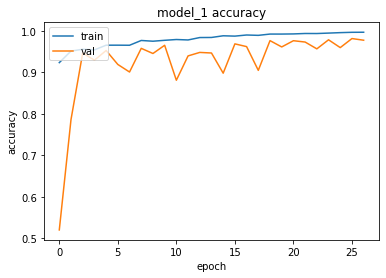

time: 189 ms


In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model_1 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
submit = pd.read_csv("/content/drive/My Drive/dog_vs_cat/sample_submission.csv") 
print(submit.head())

   id  label
0   1    0.5
1   2    0.5
2   3    0.5
3   4    0.5
4   5    0.5
time: 236 ms


In [ ]:
# model.load_weights('last_model.h5')
model.load_weights('best_model.h5')

time: 5.2 s


In [ ]:
# test_generator.reset()

time: 807 µs


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        directory = '/content/data/',
        classes=['test'],
        class_mode=None,
        target_size=(224, 224),
        color_mode="rgb",
        shuffle = False,
        batch_size=1)

filenames = test_generator.filenames
nb_samples = len(filenames)

predict = model.predict_generator(test_generator,steps = nb_samples)

Found 12500 images belonging to 1 classes.
Instructions for updating:
Please use Model.predict, which supports generators.
time: 1min 33s


In [ ]:
print(predict[0])
print(filenames[0])

[1.]
test/1.jpg
time: 1.42 ms


In [ ]:
for i in range(len(predict)):
  id = filenames[i]
  id = id.split('/')[1]
  id = id[:-4]
  pred = predict[i]
  idx = submit.index[submit.id == int(id)]
  submit.at[idx,'label'] = pred

time: 12.8 s


In [ ]:
submit.head()

,id,label
0,1,1.000000e+00
1,2,1.000000e+00
2,3,1.000000e+00
3,4,1.000000e+00
4,5,2.064481e-18


time: 14.4 ms


In [ ]:
submit.to_csv('/content/drive/My Drive/dog_vs_cat/submission.csv', index=False)


time: 338 ms
